# Analyze Text of Polish Judgements


In [ ]:
# | eval: false
from datasets import load_from_disk
import string
import seaborn as sns
import matplotlib.pyplot as plt

from juddges.settings import PL_JUDGEMENTS_PATH_TEXTS

In [ ]:
# | eval: false
ds = load_from_disk(dataset_path=PL_JUDGEMENTS_PATH_TEXTS)

In [ ]:
# | eval: false
def tagger(item):
    text = item["content"]
    dummy_tokens = text.split()

    item["chars"] = len(text)
    item["num_dummy_tokens"] = len(dummy_tokens)
    item["num_non_ws_tokens"] = sum(
        1 for tok in dummy_tokens if any(char not in string.punctuation for char in tok.strip())
    )

    return item


ds = ds.map(tagger, num_proc=44)
ds.cleanup_cache_files()

Map (num_proc=44):   0%|          | 0/408423 [00:00<?, ? examples/s]

0

In [ ]:
# | eval: false
stats = (
    ds.select_columns(["_id", "type", "chars", "num_dummy_tokens", "num_non_ws_tokens"])
    .to_pandas()
    .convert_dtypes(dtype_backend="pyarrow")
)
stats["type"] = stats["type"].astype("category")
stats.head()

,_id,type,chars,num_dummy_tokens,num_non_ws_tokens
0,154505000005127_XVII_AmA_000014_1994_Uz_1994-0...,"SENTENCE, REASON",28109,3344,3323
1,151500000001006_II_AKa_000031_1998_Uz_2013-02-...,"SENTENCE, REASON",61750,7764,7710
2,151500000001006_II_AKa_000043_1999_Uz_1999-04-...,"SENTENCE, REASON",8038,903,901
3,151500000001006_II_AKa_000072_1999_Uz_1999-05-...,"SENTENCE, REASON",8129,924,922
4,151500000001006_II_AKa_000115_1999_Uz_1999-05-...,"SENTENCE, REASON",10920,1293,1292


[Text(0.5, 1.0, '#tokens distribution')]

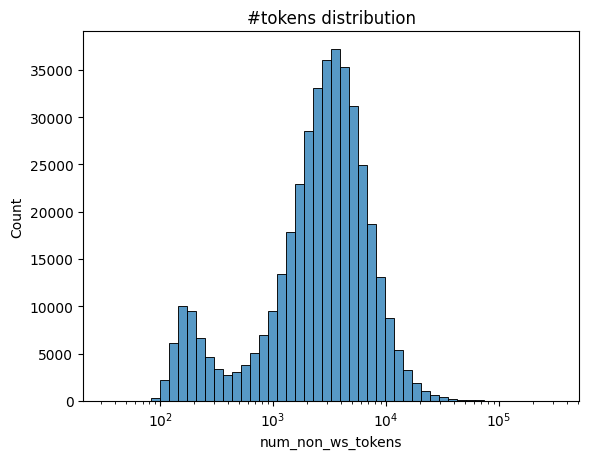

In [ ]:
# | eval: false
ax = sns.histplot(
    x=stats["num_non_ws_tokens"],
    log_scale=True,
    bins=50,
)
ax.set(title="#tokens distribution")

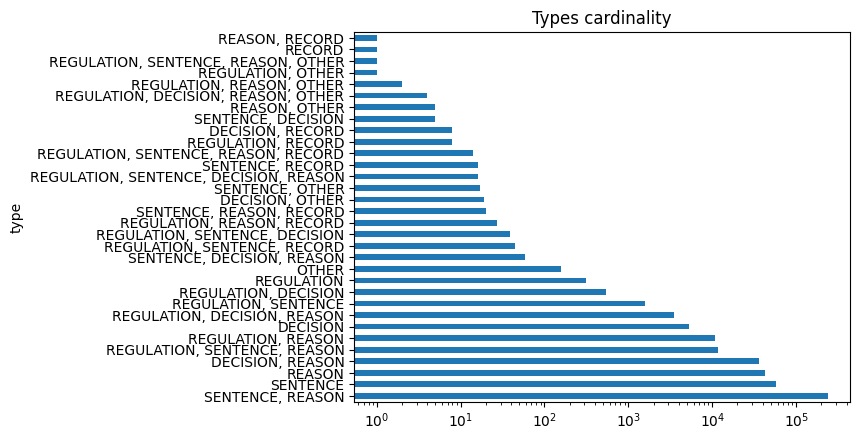

In [ ]:
# | eval: false
card_order = stats["type"].value_counts().index.tolist()
data = stats["type"].value_counts().plot.barh(logx=True, title="Types cardinality")

<Axes: title={'center': 'Per type text length ditribution'}, xlabel='num_non_ws_tokens', ylabel='type'>

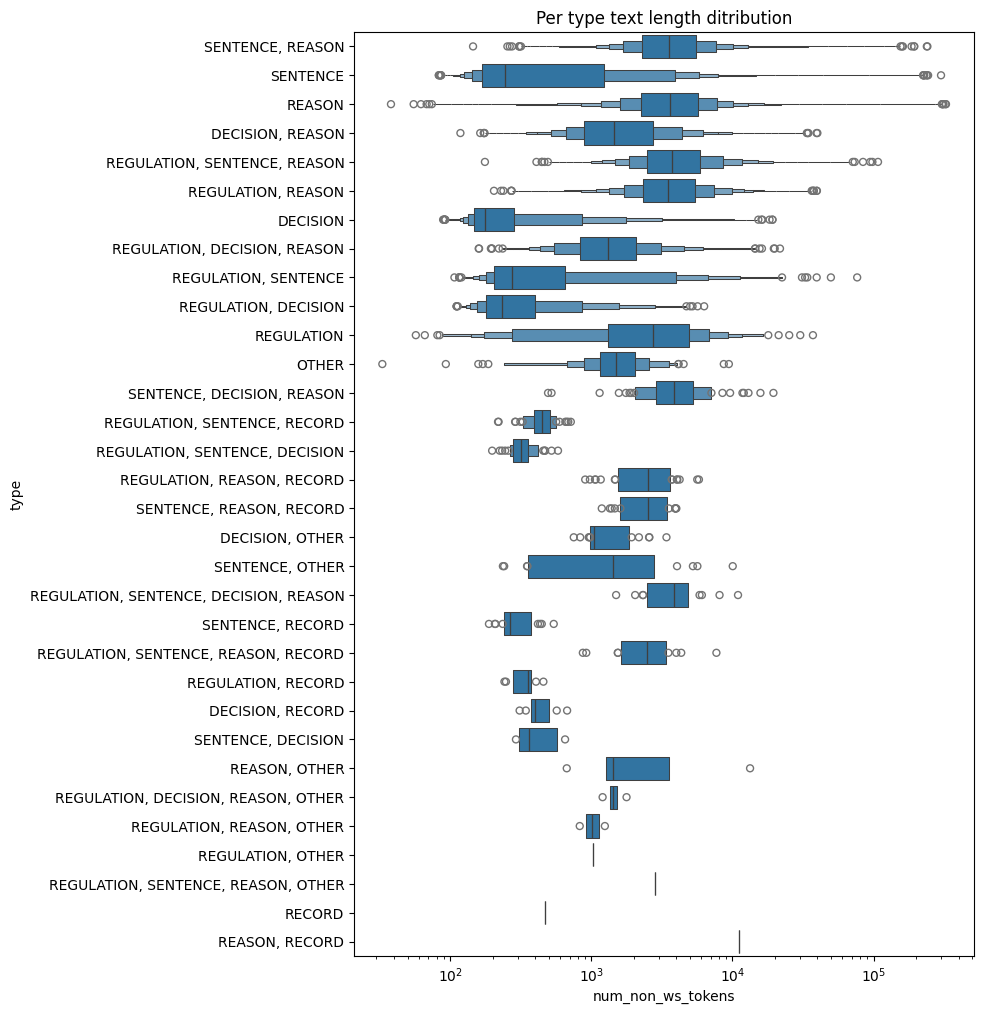

In [ ]:
# | eval: false
# sns.displot(data=stats, x="num_non_ws_tokens", col="type", col_wrap=3, log_scale=(True, False), facet_kws=dict(sharey=False, sharex=False), kind="hist", bins=25)

_, ax = plt.subplots(figsize=(8, 12))
ax.set(title="Per type text length ditribution")
sns.boxenplot(data=stats, y="type", x="num_non_ws_tokens", order=card_order, log_scale=True)

# Tokenize


In [ ]:
# | eval: false
from transformers import AutoTokenizer

In [ ]:
# | eval: false
tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large")
ds = ds.map(
    lambda examples: tokenizer(examples["content"], padding=False, truncation=False),
    batched=True,
    num_proc=44,
)

In [ ]:
# | eval: false
tokenized = []
for item in ds:
    tokenized.append({"num_tokens": len(item["input_ids"])})

In [ ]:
# | eval: false
sns.histplot(tokenized, bins=50)